In [1]:
# First we obtain data to compute the log D/P ratio
# The FRED MD dataset is a good (free) source of data
# See 
# Bai, Jushan and Ng, Serena (2002), "Determining the number of factors in approximate factor models".
# McCracken, Michael W. and Ng, Serena (2015), "FRED-MD and FRED-QD: Monthly and Quarterly Databases for Macroeconomic Research".
# Bai, Jushan and Ng, Serena (2019), "Matrix Completion, Counterfactuals, and Factor Analysis of Missing Data".
	

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
url ="https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)
# keep S&P div yield and S&P 500
df = df[['S&P div yield', 'S&P 500']]

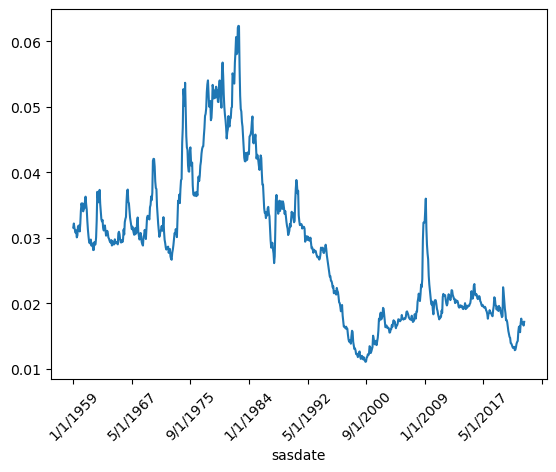

In [2]:
# Transform suggests a transformation of the series given a code, but we stick to the Campbell and Shiller definition
df = df.iloc[1:]
# remove nan
df = df.dropna()

# rename S&P div yield to D/P
# rename S&P 500 to P

df = df.rename(columns={'S&P div yield': 'D/P', 'S&P 500': 'P'})

# D/P is expressed in percentage,
df['D/P'] = df['D/P']/100

# recover D by multiplying by P (and divide by 100)
df['D'] = df['D/P']*df['P']

# compute Delta log D 
df['Delta d'] = np.log(df['D']).diff()
# take logs to D/P 
df['d-p'] = np.log(df['D/P'])
# rename D/P to d-p 

# compute log returns to P
df['r'] = np.log((df['P']+df['D'])/df['P'].shift(1))
df['p'] = np.log(df['P'])

# plot D/P
df['D/P'].plot()
# rotate axis
plt.xticks(rotation=45);

<Axes: xlabel='date'>

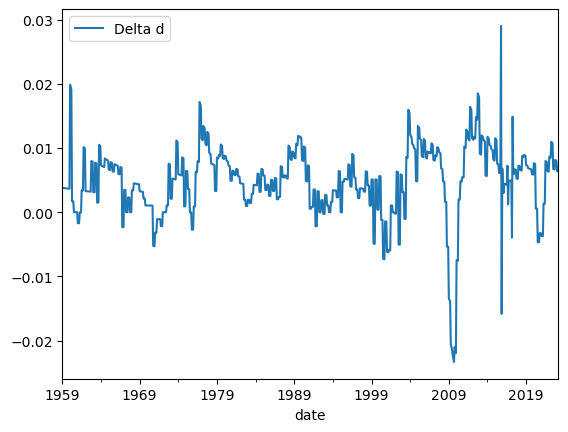

In [3]:
# rename index to date
df.index.name = 'date'
# make index datetime, format is month day year
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
# plot some of the graphs
df[['Delta d']].plot()

In [4]:
# add two more variables r at t +1 and Delta d at t +1
df['r+1'] = df['r'].shift(-1)
df['Delta d+1'] = df['Delta d'].shift(-1)

In [5]:
# compute forward returns, sum between r today and r 60 months later
tau = 12*6
# first compute cum sums
df['cum_r'] = df['r'].cumsum()
df[f'r+{tau}'] = df['cum_r'].shift(-tau) - df['cum_r']
# remove nan
df = df.dropna()
# regress r+60 on d-p 
import statsmodels.api as sm
X = df['d-p']
y = df[f'r+{tau}']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() # recall that these are not necessarily the right standard errors
print(model.summary())

# Compute Newey-West standard errors
# See https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html
se = model.get_robustcov_results(cov_type='HAC', maxlags=tau).bse
# adjust t statistics
t = model.params/se
# print results
print("----------------------------------------")
print("Model results using Newey-West standard errors, t-statistics in parentheses") 
print(f"r+{tau} = {model.params[0]:.4f} ({t[0]:.4f}) +{model.params[1]:.4f} ({t[1]:.4f}) d-p  ")

                            OLS Regression Results                            
Dep. Variable:                   r+72   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     5073.
Date:                Mon, 17 Jul 2023   Prob (F-statistic):          7.61e-322
Time:                        14:26:59   Log-Likelihood:                -109.57
No. Observations:                 698   AIC:                             223.1
Df Residuals:                     696   BIC:                             232.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4713      0.099     95.708      0.0

<Axes: xlabel='date'>

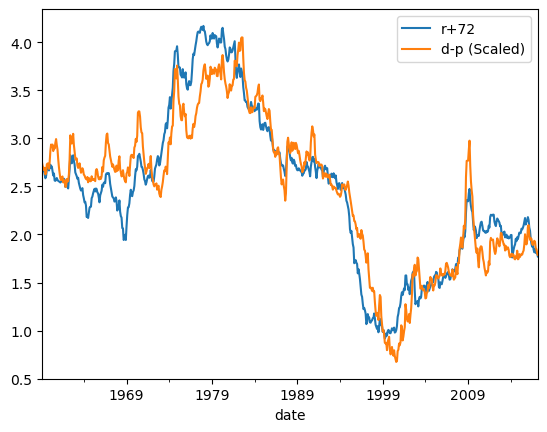

In [6]:
# plot f'r+{tau}' and d-p 
df['d-p (Scaled)'] = df['d-p']*model.params[1]+model.params[0]
df[[f'r+{tau}', 'd-p (Scaled)']].plot()

In [7]:
# Sign restrictions? Regress r+1 on d-p and Delta d+1 on d-p, store the residuals
# regress r+1 on d-p and Delta d+1 on d-p, store the residuals
X = (df['d-p'] - df['d-p'].mean())

y = (df['r+1'] - df['r+1'].mean())*100
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_r = model.params[1]
print(f"b_r = {b_r}")

                            OLS Regression Results                            
Dep. Variable:                    r+1   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     86.10
Date:                Mon, 17 Jul 2023   Prob (F-statistic):           2.13e-19
Time:                        14:27:19   Log-Likelihood:                -1853.7
No. Observations:                 698   AIC:                             3711.
Df Residuals:                     696   BIC:                             3721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.776e-16      0.131  -2.13e-15      1.0

In [8]:
X = (df['d-p'] - df['d-p'].mean())
y = df['Delta d+1']*100
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_d = model.params[1]
print(f"b_d = {b_d}")

                            OLS Regression Results                            
Dep. Variable:              Delta d+1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.08108
Date:                Mon, 17 Jul 2023   Prob (F-statistic):              0.776
Time:                        14:27:34   Log-Likelihood:                -605.45
No. Observations:                 698   AIC:                             1215.
Df Residuals:                     696   BIC:                             1224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4693      0.022     21.492      0.0

In [9]:
# compute rho for long term reg
x_0 = - df['d-p'].mean()
rho = np.exp(x_0)/(np.exp(x_0)+1)

T = 100 # number of periods
# compute the weighted sum between r+j and r+T weighted by rho**j
ret_ = []
div_=[]
# time index
time_ = np.arange(len(df))
for t in time_:
    try:
        lhs = sum([rho**j*df['r+1'].iloc[t+j] for j in range(T)])
        df.loc[df.index[t], 'rho_r+T'] = lhs
        # compute the weighted sum between Delta d+j and Delta d+T weighted by rho**j
        lhs = sum([rho**j*df['Delta d+1'].iloc[t+j] for j in range(T)])
        df.loc[df.index[t], 'rho_d+T'] = lhs
    except:
        pass


# regressions
temp_df = df.dropna()
X = temp_df['d-p']
y = temp_df['rho_r+T']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_r = model.params[1]
print(f"b_r = {b_r}")

X = temp_df['d-p']
y = temp_df['rho_d+T']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_d = model.params[1]
print(f"b_d = {b_d}")

print(f"b_r-b_d = {b_r-b_d}")

                            OLS Regression Results                            
Dep. Variable:                rho_r+T   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.031e+04
Date:                Mon, 17 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:27:48   Log-Likelihood:                 545.84
No. Observations:                 599   AIC:                            -1088.
Df Residuals:                     597   BIC:                            -1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7966      0.035    135.356      0.0